In [1]:
# install dependcies
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
import sys

drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/project')

Mounted at /content/drive


In [17]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
import math
import cv2

import matplotlib.patches as patches
import matplotlib.pyplot as plt

import csv
import os
from datasets import load_dataset
from CarDataAugmentation import get_preprocess_function, rotate_image, rotate_bounding_box
import carParser
from tensorflow.keras.utils import plot_model

from sklearn.metrics import precision_recall_curve, auc

In [4]:
# This model will define the bbox as [x, y, width, height]
def rectangle_patch(bbox, c='r'):
  return patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor=c, facecolor='none')

class_index_to_label = {
    0: "License Plate",
    1: "No License Plate"
}

def one_hot_to_string(one_hot_encoding):
    class_index = np.argmax(one_hot_encoding)
    return class_index_to_label[class_index]


In [5]:
# https://huggingface.co/datasets/keremberke/license-plate-object-detection
ds = load_dataset("keremberke/license-plate-object-detection", name="full")
example = ds['train'][0]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [6]:
example

{'image_id': 5152,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=472x303>,
 'width': 472,
 'height': 303,
 'objects': {'id': [5353],
  'area': [9191],
  'bbox': [[223.0, 140.0, 101.0, 91.0]],
  'category': [0]}}

(-0.5, 471.5, 302.5, -0.5)

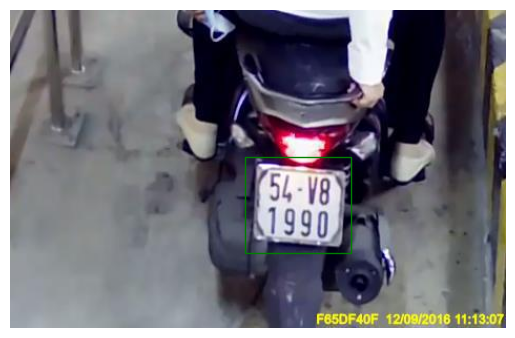

In [7]:
image = example['image']
bbox = example['objects']['bbox'][0]
fig, ax = plt.subplots()
ax.imshow(image)
ax.add_patch(rectangle_patch(bbox, c='g'))
plt.axis("off")

In [8]:
image_size = (512, 512)
input_size = 512
CLASSES = 2


def preprocess_image(image, label=None):
  # Resize the image to the required input shape
  resized_image = tf.image.resize_with_pad(image=image, target_height=input_size, target_width=input_size)

  # Normalize the pixel values to the range [0, 1]
  resized_image = resized_image / 255.0

  if label is None:
    return resized_image

  # Check if transform label calculations doesn't accidentally decrease the size of the bounding box or move it slightly
  # transform the label
  resize_scale_width = input_size / image.shape[1]
  resize_scale_height = input_size / image.shape[0]

  # Determine the resize scale to use (minimum or maximum)
  resize_scale = min(resize_scale_width, resize_scale_height)

  # Calculate the padding offsets
  pad_offset_height = (input_size - image.shape[0] * resize_scale) // 2
  pad_offset_width = (input_size - image.shape[1] * resize_scale) // 2

  xmin_resized = (label[0] * resize_scale) + pad_offset_width
  ymin_resized = (label[1] * resize_scale) + pad_offset_height
  width_resized = (label[2] * resize_scale)
  height_resized = (label[3] * resize_scale)
  newLabel = np.array([xmin_resized, ymin_resized, width_resized, height_resized])


  return resized_image, newLabel


In [9]:
# Adapted from https://medium.com/mlearning-ai/building-your-own-object-detector-from-scratch-with-tensorflow-bfeadfaddad8
from tensorflow.keras.layers.experimental.preprocessing import RandomContrast


def build_feature_extractor(inputs):

    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(input_size, input_size, 3))(inputs)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    return x

def build_model_adaptor(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    return x

def build_classifier_head(inputs):
    return tf.keras.layers.Dense(CLASSES, activation='softmax', name = 'classifier_head')(inputs)

def build_regressor_head(inputs):
    return tf.keras.layers.Dense(units = 4, name = 'regressor_head')(inputs)

# The data augmentation is not from the source code. We added it on our own
# For now, we are only using RandomContrast on the images
def build_data_augmentation(inputs):
    augmented = RandomContrast(factor=0.2)(inputs)
    # augmented = RandomHue(factor=0.1)(augmented)
    return augmented

def build_model(inputs):

    augmented = build_data_augmentation(inputs)

    feature_extractor_1 = build_feature_extractor(augmented)
    feature_extractor_2 = build_feature_extractor(augmented)

    model_adaptor_1 = build_model_adaptor(feature_extractor_1)
    model_adaptor_2 = build_model_adaptor(feature_extractor_2)

    classification_head = build_classifier_head(model_adaptor_1)
    regressor_head = build_regressor_head(model_adaptor_2)

    model = tf.keras.Model(inputs = inputs, outputs = [regressor_head, classification_head])
    #model = tf.keras.Model(inputs = inputs, outputs = regressor_head)

    return model


In [10]:


def preprocess_wrapper(image, label):
    processed_image, processed_label = tf.py_function(
        preprocess_image,
        [image, label],
        [tf.float32, tf.float32]
    )
    # Set explicit shapes for the tensors
    processed_image.set_shape((512, 512, 3))  # Replace with your image shape
    processed_label.set_shape((4,))  # Assuming your bounding box labels have 4 values

    return processed_image, processed_label, tf.constant([1, 0], dtype=tf.float32)


# Random Rotation is also data augmentation but we cannot add it to the model because it also changes the label
def random_rotation(image, label):
  angle = np.random.uniform(-10, 10)
  label = label.numpy()
  image = image.numpy()

  rect = carParser.Rectangle(label[0], label[1], label[0]+label[2], label[1]+label[3])
  pivot = rect.center()

  new_image = rotate_image(image, angle, pivot=pivot)
  new_label = rotate_bounding_box(rect, angle, pivot).numpy()


  new_label[2] = new_label[2]-new_label[0]
  new_label[3] = new_label[3]-new_label[1]
  return new_image, new_label

def random_rotation_wrapper(image, label, classNum):
  processed_image, processed_label = tf.py_function(
        random_rotation,
        [image, label],
        [tf.float32, tf.float32]
    )
  return processed_image, processed_label, classNum

def random_license_blur(image, label):

  # Define the coordinates of the region you want to blur
  label = label.numpy()
  x1, y1, x2, y2 = math.floor(label[0]), math.floor(label[1]), math.ceil(label[2]+label[0]), math.ceil(label[3]+label[1])

  # Get the region of interest (ROI)
  image = image.numpy()
  roi = image[y1:y2, x1:x2]

  # Apply Gaussian blur to the ROI
  #blurred_roi = cv2.GaussianBlur(roi, (51, 51), 0)
  black_roi = np.zeros_like(roi)

  # Replace the original ROI with the blurred ROI
  image[y1:y2, x1:x2] = black_roi
  return image, label


def random_license_blur_wrapper(image, label, classNum):

  def apply_blur():
    a, b = tf.py_function(
        random_license_blur,
        [image, label],
        [tf.float32, tf.float32]
    )
    return [a, b, tf.constant([0, 1], dtype=tf.float32)]


  prob = tf.random.uniform(shape=(), minval=0.0, maxval=1.0)

  processed_image, processed_label, processed_classNum = tf.cond(
        prob < 0.5,  # 50% probability
        apply_blur,
        lambda: [image, label, classNum]
  )
  return processed_image, processed_label, processed_classNum

def give_to_train(image, label, classNum):
  return image, (label, classNum)

In [11]:
def generate_train():
    for data in ds["train"]:
        yield (data["image"], data["objects"]['bbox'][0])

def generate_val():
    for data in ds["validation"]:
        yield (data["image"], data["objects"]['bbox'][0])

def generate_test():
    for data in ds["test"]:
        yield (data["image"], data["objects"]['bbox'][0])


In [12]:
output_signature = (tf.TensorSpec(shape=(None, None, 3), dtype=tf.float32), tf.TensorSpec(shape=(4,), dtype=tf.float32))


# Create a TensorFlow Datasets
train_ds = tf.data.Dataset.from_generator(
    generate_train,
    output_signature=output_signature,
)

val_ds = tf.data.Dataset.from_generator(
    generate_val,
    output_signature=output_signature,
)


test_ds = tf.data.Dataset.from_generator(
    generate_test,
    output_signature=output_signature,
)

In [13]:

BATCH_SIZE = 32
train_preprocess = train_ds.map(preprocess_wrapper).map(random_license_blur_wrapper).map(random_rotation_wrapper).map(give_to_train).batch(BATCH_SIZE).prefetch(1)
val_preprocess = val_ds.map(preprocess_wrapper).map(random_license_blur_wrapper).map(give_to_train).batch(BATCH_SIZE).prefetch(1)

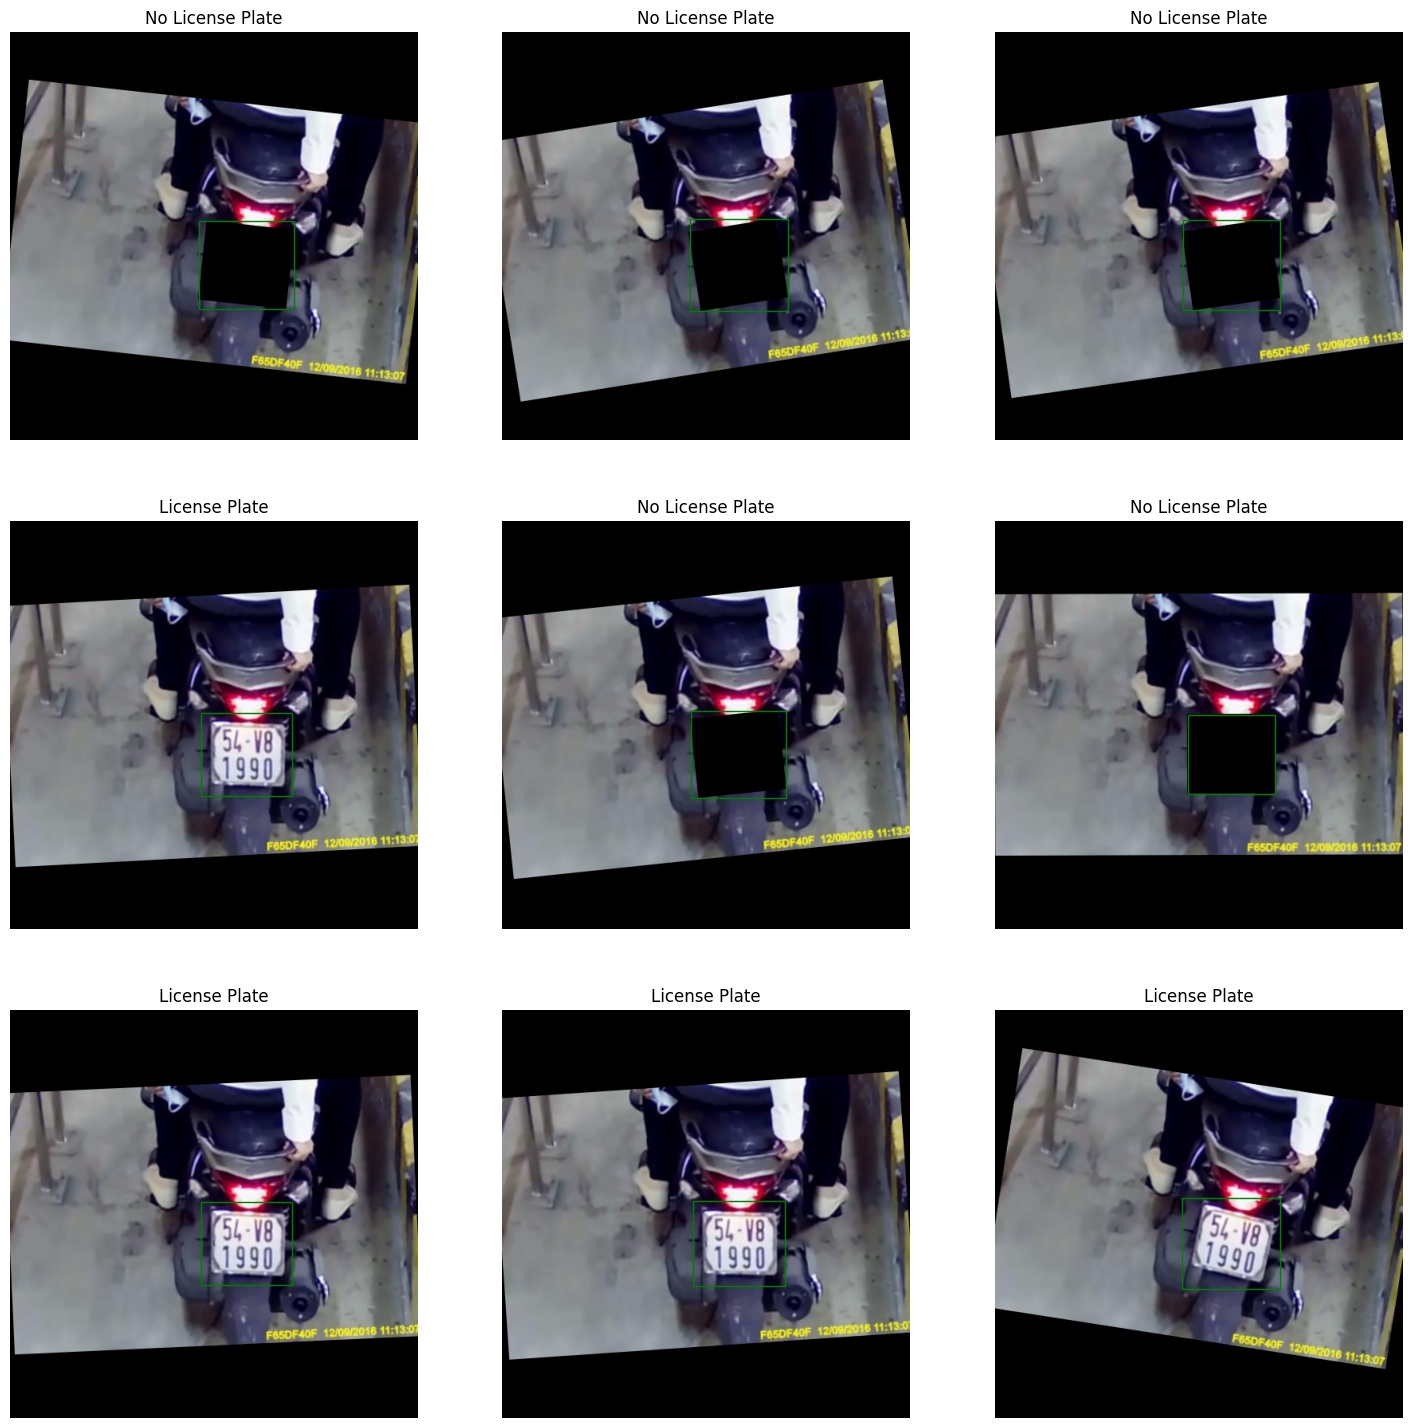

In [14]:


plt.figure(figsize=(18, 18))
for i in range(9):
  for data in train_ds.map(preprocess_wrapper).map(random_license_blur_wrapper).map(random_rotation_wrapper).map(give_to_train).take(1):
    image = data[0]
    label = data[1]
    box = label[0]
    classNum = label[1]
    ax = plt.subplot(3, 3, i+1)
    ax.imshow(image)

    classNum = classNum.numpy()
    classified = one_hot_to_string(classNum)
    ax.add_patch(rectangle_patch(box, c='g'))
    ax.set_title(classified)
    plt.axis("off")

In [25]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Create the model
checkpoint_path = "/content/drive/MyDrive/project/FinalModel/training_1/best_model.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint = ModelCheckpoint(checkpoint_dir,
                             monitor='val_loss',  # Monitor validation loss
                             verbose=1,
                             save_best_only=True,
                             mode='min')  # Save the lowest validation loss


model = build_model(tf.keras.layers.Input(shape=(input_size, input_size, 3)))
model.compile(optimizer=tf.keras.optimizers.Adam(),
    loss = {'classifier_head' : 'categorical_crossentropy', 'regressor_head' : 'mse' },
   # loss_weights={'classifier_head': 1.0, 'regressor_head': 1.0},

    metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' })

EPOCHS = 20

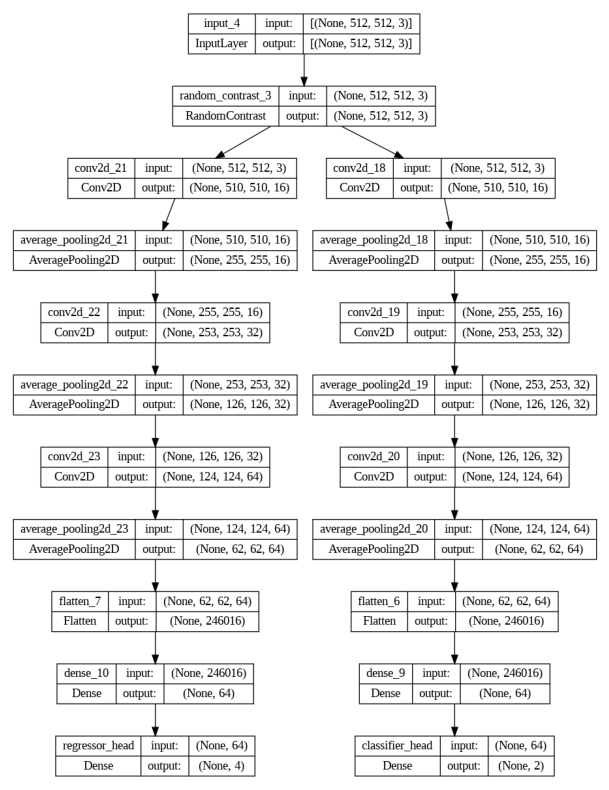

In [31]:
plt.figure(figsize=(10, 10))
plot_model(model, show_shapes=True, show_layer_names=True, to_file='/content/drive/MyDrive/project/FinalModel/model_vis.png')
im = plt.imread('/content/drive/MyDrive/project/FinalModel/model_vis.png')
plt.imshow(im)
plt.axis('off')
plt.show()

In [ ]:
history = model.fit(train_preprocess,
                    steps_per_epoch=None,
                    validation_data=val_preprocess, validation_steps=None,
                    epochs=EPOCHS,
                    callbacks=[checkpoint])

Epoch 1/20
    193/Unknown - 200s 964ms/step - loss: 3675.6191 - regressor_head_loss: 3675.0066 - classifier_head_loss: 0.6118 - regressor_head_mse: 3675.0066 - classifier_head_accuracy: 0.6807
Epoch 1: val_loss improved from inf to 1483.34326, saving model to /content/drive/MyDrive/project/FinalModel/training_1


193/193 [==============================] - 242s 1s/step - loss: 3675.6191 - regressor_head_loss: 3675.0066 - classifier_head_loss: 0.6118 - regressor_head_mse: 3675.0066 - classifier_head_accuracy: 0.6807 - val_loss: 1483.3433 - val_regressor_head_loss: 1482.9373 - val_classifier_head_loss: 0.4060 - val_regressor_head_mse: 1482.9373 - val_classifier_head_accuracy: 0.8283
Epoch 2/20
193/193 [==============================] - ETA: 0s - loss: 1285.2795 - regressor_head_loss: 1284.8453 - classifier_head_loss: 0.4341 - regressor_head_mse: 1284.8453 - classifier_head_accuracy: 0.7887
Epoch 2: val_loss improved from 1483.34326 to 1041.11890, saving model to /content/drive/MyDrive/project/FinalModel/training_1


193/193 [==============================] - 228s 1s/step - loss: 1285.2795 - regressor_head_loss: 1284.8453 - classifier_head_loss: 0.4341 - regressor_head_mse: 1284.8453 - classifier_head_accuracy: 0.7887 - val_loss: 1041.1189 - val_regressor_head_loss: 1040.7659 - val_classifier_head_loss: 0.3527 - val_regressor_head_mse: 1040.7659 - val_classifier_head_accuracy: 0.8317
Epoch 3/20
193/193 [==============================] - ETA: 0s - loss: 1015.7743 - regressor_head_loss: 1015.4426 - classifier_head_loss: 0.3318 - regressor_head_mse: 1015.4426 - classifier_head_accuracy: 0.8499
Epoch 3: val_loss improved from 1041.11890 to 1002.08313, saving model to /content/drive/MyDrive/project/FinalModel/training_1


193/193 [==============================] - 226s 1s/step - loss: 1015.7743 - regressor_head_loss: 1015.4426 - classifier_head_loss: 0.3318 - regressor_head_mse: 1015.4426 - classifier_head_accuracy: 0.8499 - val_loss: 1002.0831 - val_regressor_head_loss: 1001.8234 - val_classifier_head_loss: 0.2600 - val_regressor_head_mse: 1001.8234 - val_classifier_head_accuracy: 0.8890
Epoch 4/20
193/193 [==============================] - ETA: 0s - loss: 913.0154 - regressor_head_loss: 912.7513 - classifier_head_loss: 0.2643 - regressor_head_mse: 912.7513 - classifier_head_accuracy: 0.8821
Epoch 4: val_loss improved from 1002.08313 to 917.45459, saving model to /content/drive/MyDrive/project/FinalModel/training_1


193/193 [==============================] - 228s 1s/step - loss: 913.0154 - regressor_head_loss: 912.7513 - classifier_head_loss: 0.2643 - regressor_head_mse: 912.7513 - classifier_head_accuracy: 0.8821 - val_loss: 917.4546 - val_regressor_head_loss: 917.1722 - val_classifier_head_loss: 0.2823 - val_regressor_head_mse: 917.1722 - val_classifier_head_accuracy: 0.8827
Epoch 5/20
193/193 [==============================] - ETA: 0s - loss: 807.4464 - regressor_head_loss: 807.2020 - classifier_head_loss: 0.2444 - regressor_head_mse: 807.2020 - classifier_head_accuracy: 0.8930
Epoch 5: val_loss improved from 917.45459 to 885.34985, saving model to /content/drive/MyDrive/project/FinalModel/training_1


193/193 [==============================] - 232s 1s/step - loss: 807.4464 - regressor_head_loss: 807.2020 - classifier_head_loss: 0.2444 - regressor_head_mse: 807.2020 - classifier_head_accuracy: 0.8930 - val_loss: 885.3499 - val_regressor_head_loss: 885.1242 - val_classifier_head_loss: 0.2256 - val_regressor_head_mse: 885.1242 - val_classifier_head_accuracy: 0.8992
Epoch 6/20
193/193 [==============================] - ETA: 0s - loss: 739.0623 - regressor_head_loss: 738.8609 - classifier_head_loss: 0.2014 - regressor_head_mse: 738.8609 - classifier_head_accuracy: 0.9109
Epoch 6: val_loss improved from 885.34985 to 806.38239, saving model to /content/drive/MyDrive/project/FinalModel/training_1


193/193 [==============================] - 226s 1s/step - loss: 739.0623 - regressor_head_loss: 738.8609 - classifier_head_loss: 0.2014 - regressor_head_mse: 738.8609 - classifier_head_accuracy: 0.9109 - val_loss: 806.3824 - val_regressor_head_loss: 806.1794 - val_classifier_head_loss: 0.2030 - val_regressor_head_mse: 806.1794 - val_classifier_head_accuracy: 0.9161
Epoch 7/20
193/193 [==============================] - ETA: 0s - loss: 669.6835 - regressor_head_loss: 669.4904 - classifier_head_loss: 0.1932 - regressor_head_mse: 669.4904 - classifier_head_accuracy: 0.9114
Epoch 7: val_loss did not improve from 806.38239
193/193 [==============================] - 223s 1s/step - loss: 669.6835 - regressor_head_loss: 669.4904 - classifier_head_loss: 0.1932 - regressor_head_mse: 669.4904 - classifier_head_accuracy: 0.9114 - val_loss: 840.4069 - val_regressor_head_loss: 840.2404 - val_classifier_head_loss: 0.1667 - val_regressor_head_mse: 840.2404 - val_classifier_head_accuracy: 0.9207
Epoch 8

193/193 [==============================] - 228s 1s/step - loss: 539.4336 - regressor_head_loss: 539.2877 - classifier_head_loss: 0.1459 - regressor_head_mse: 539.2877 - classifier_head_accuracy: 0.9336 - val_loss: 755.3369 - val_regressor_head_loss: 755.2061 - val_classifier_head_loss: 0.1306 - val_regressor_head_mse: 755.2061 - val_classifier_head_accuracy: 0.9411
Epoch 11/20
193/193 [==============================] - ETA: 0s - loss: 478.6805 - regressor_head_loss: 478.5475 - classifier_head_loss: 0.1331 - regressor_head_mse: 478.5475 - classifier_head_accuracy: 0.9398
Epoch 11: val_loss did not improve from 755.33685
193/193 [==============================] - 226s 1s/step - loss: 478.6805 - regressor_head_loss: 478.5475 - classifier_head_loss: 0.1331 - regressor_head_mse: 478.5475 - classifier_head_accuracy: 0.9398 - val_loss: 864.9886 - val_regressor_head_loss: 864.8603 - val_classifier_head_loss: 0.1281 - val_regressor_head_mse: 864.8603 - val_classifier_head_accuracy: 0.9365
Epoch

193/193 [==============================] - 234s 1s/step - loss: 411.0804 - regressor_head_loss: 410.9716 - classifier_head_loss: 0.1086 - regressor_head_mse: 410.9716 - classifier_head_accuracy: 0.9487 - val_loss: 707.1920 - val_regressor_head_loss: 707.0724 - val_classifier_head_loss: 0.1194 - val_regressor_head_mse: 707.0724 - val_classifier_head_accuracy: 0.9507
Epoch 16/20
193/193 [==============================] - ETA: 0s - loss: 386.4109 - regressor_head_loss: 386.3000 - classifier_head_loss: 0.1108 - regressor_head_mse: 386.3000 - classifier_head_accuracy: 0.9508
Epoch 16: val_loss did not improve from 707.19202
193/193 [==============================] - 230s 1s/step - loss: 386.4109 - regressor_head_loss: 386.3000 - classifier_head_loss: 0.1108 - regressor_head_mse: 386.3000 - classifier_head_accuracy: 0.9508 - val_loss: 741.1443 - val_regressor_head_loss: 741.0248 - val_classifier_head_loss: 0.1196 - val_regressor_head_mse: 741.0248 - val_classifier_head_accuracy: 0.9456
Epoch

193/193 [==============================] - 233s 1s/step - loss: 359.1098 - regressor_head_loss: 359.0068 - classifier_head_loss: 0.1029 - regressor_head_mse: 359.0068 - classifier_head_accuracy: 0.9483 - val_loss: 694.8658 - val_regressor_head_loss: 694.7369 - val_classifier_head_loss: 0.1291 - val_regressor_head_mse: 694.7369 - val_classifier_head_accuracy: 0.9473
Epoch 18/20
193/193 [==============================] - ETA: 0s - loss: 321.5403 - regressor_head_loss: 321.4387 - classifier_head_loss: 0.1017 - regressor_head_mse: 321.4387 - classifier_head_accuracy: 0.9514
Epoch 18: val_loss did not improve from 694.86578
193/193 [==============================] - 233s 1s/step - loss: 321.5403 - regressor_head_loss: 321.4387 - classifier_head_loss: 0.1017 - regressor_head_mse: 321.4387 - classifier_head_accuracy: 0.9514 - val_loss: 759.6159 - val_regressor_head_loss: 759.5156 - val_classifier_head_loss: 0.1002 - val_regressor_head_mse: 759.5156 - val_classifier_head_accuracy: 0.9598
Epoch

193/193 [==============================] - 236s 1s/step - loss: 318.0208 - regressor_head_loss: 317.9271 - classifier_head_loss: 0.0937 - regressor_head_mse: 317.9271 - classifier_head_accuracy: 0.9566 - val_loss: 682.7131 - val_regressor_head_loss: 682.5708 - val_classifier_head_loss: 0.1423 - val_regressor_head_mse: 682.5708 - val_classifier_head_accuracy: 0.9518
Epoch 20/20
193/193 [==============================] - ETA: 0s - loss: 288.1245 - regressor_head_loss: 288.0380 - classifier_head_loss: 0.0865 - regressor_head_mse: 288.0380 - classifier_head_accuracy: 0.9585
Epoch 20: val_loss did not improve from 682.71307
193/193 [==============================] - 232s 1s/step - loss: 288.1245 - regressor_head_loss: 288.0380 - classifier_head_loss: 0.0865 - regressor_head_mse: 288.0380 - classifier_head_accuracy: 0.9585 - val_loss: 720.7849 - val_regressor_head_loss: 720.6713 - val_classifier_head_loss: 0.1139 - val_regressor_head_mse: 720.6713 - val_classifier_head_accuracy: 0.9513


In [ ]:
test_preprocess = test_ds.map(preprocess_wrapper).map(random_license_blur_wrapper).map(give_to_train).batch(BATCH_SIZE)

In [40]:
best_model = build_model(tf.keras.layers.Input(shape=(input_size, input_size, 3)))
best_model.compile(optimizer=tf.keras.optimizers.Adam(),
    loss = {'classifier_head' : 'categorical_crossentropy', 'regressor_head' : 'mse' },
    #loss = {'regressor_head' : 'mse' },
    metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' })
    #metrics = {'regressor_head' : 'mse' })

best_model.load_weights('/content/drive/MyDrive/project/FinalModel/training_1')



In [41]:
# Source code from: https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou


def bb_intersection_over_union_xywh(boxA, boxB):
	boxA = [boxA[0], boxA[1], boxA[0]+boxA[2], boxA[1]+boxA[3]]
	boxB = [boxB[0], boxB[1], boxB[0]+boxB[2], boxB[1]+boxB[3]]
	return bb_intersection_over_union(boxA, boxB)

In [52]:
test_preprocess = test_ds.map(preprocess_wrapper).map(random_license_blur_wrapper).map(give_to_train).batch(BATCH_SIZE)
plt.figure(figsize=(16, 32))

total = 0
count = 0
for batch in test_preprocess.take(1):
  predictions = best_model(batch[0], training=False)
  boxes_pred = predictions[0]
  labels_pred = predictions[1]

  images = batch[0]
  outputs = batch[1]
  for i in range(len(boxes_pred)):
    im = images[i]

    box = outputs[0][i]
    label = outputs[1][i]

    # print(im, box, label)


    box_pred = boxes_pred[i]
    label_pred = labels_pred[i]

    IoU = bb_intersection_over_union_xywh(box, box_pred)
    count+=1
    total += IoU

    ax = plt.subplot(8, 4, i + 1)
    ax.imshow(im)
    ax.add_patch(rectangle_patch(box_pred, c='g'))
    ax.add_patch(rectangle_patch(box, c='r'))
    ax.set_title(f"{one_hot_to_string(label_pred.numpy())}, IoU={IoU:.2f}")
    plt.axis("off")

print(f"Average IoU: {total/count:.4f}")


Output hidden; open in https://colab.research.google.com to view.

In [83]:
test_preprocess = test_ds.map(preprocess_wrapper).map(random_license_blur_wrapper).map(give_to_train).batch(BATCH_SIZE)
y_true = []
y_pred = []
correct_predictions = 0
total_IoU = 0
count = 0
for batch in test_preprocess:
  predictions = best_model(batch[0], training=False)
  boxes_pred = predictions[0]
  labels_pred = predictions[1]

  images = batch[0]
  outputs = batch[1]
  for i in range(len(images)):
    im = images[i]


    box = outputs[0][i]
    label = outputs[1][i]

    y_true.append(label.numpy())

    box_pred = boxes_pred[i]
    label_pred = labels_pred[i]
    y_pred.append(label_pred.numpy())

    IoU = bb_intersection_over_union_xywh(box, box_pred)
    total_IoU += IoU

    true_class = np.argmax(label)  # Index of true class
    pred_class = np.argmax(label_pred)  # Index of predicted class

    if true_class == pred_class:
        correct_predictions += 1

    count+=1

print(f"Average IoU for all Testing data: {total_IoU/count:.4f}")
print(f"Average Accuracy for all Testing data: {correct_predictions/count:.4f}")

InvalidArgumentError: ignored

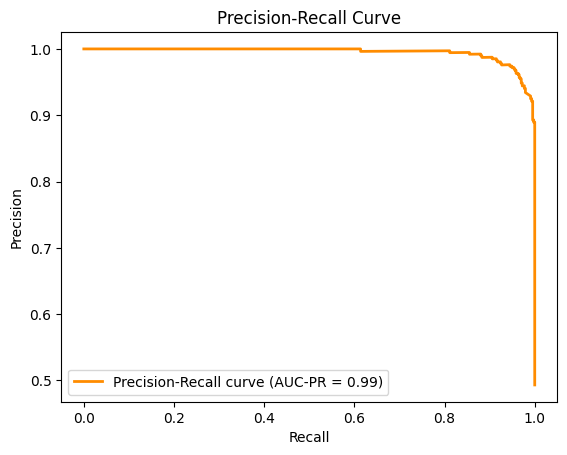

AUC-PR: 0.9947935070258638


In [64]:
y_scores = y_pred
# Index 0 is for There is License Plate, 1 is No License Plate

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

precision, recall, thresholds = precision_recall_curve(
    np.concatenate([true_class[0].ravel() for true_class in y_true]),
    np.concatenate([predicted_class[0].ravel() for predicted_class in y_scores])
)

# Calculate the area under the precision-recall curve (AUC-PR)
auc_pr = auc(recall, precision)

# Plot the Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label=f'Precision-Recall curve (AUC-PR = {auc_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

print(f'AUC-PR: {auc_pr}')

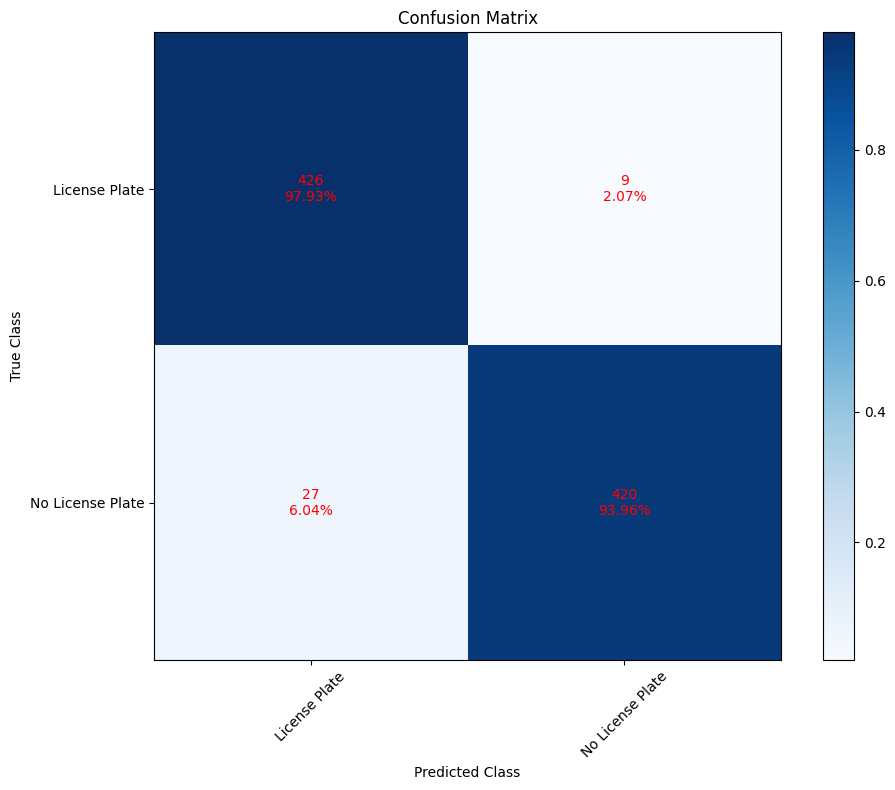

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Convert one-hot encodings to class indices
true_classes = [np.argmax(true_label) for true_label in y_true]
pred_classes = [np.argmax(pred_label) for pred_label in y_pred]

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_classes, pred_classes)

# Calculate the percentages for each class
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix as a heatmap with numbers and percentages
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix_percent, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_index_to_label))
plt.xticks(tick_marks, [class_index_to_label[i] for i in range(len(class_index_to_label))], rotation=45)
plt.yticks(tick_marks, [class_index_to_label[i] for i in range(len(class_index_to_label))])
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

# Display the numbers and percentages within each cell
for i in range(len(class_index_to_label)):
    for j in range(len(class_index_to_label)):
        plt.text(j, i, f'{conf_matrix[i, j]}\n{conf_matrix_percent[i, j]*100:.2f}%', ha='center', va='center', color='red')

plt.tight_layout()
plt.show()


In [66]:
# Extract values
TP = conf_matrix[1][1]
FP = conf_matrix[0][1]
FN = conf_matrix[1][0]
TN = conf_matrix[0][0]

# Calculate metrics
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
specificity = TN / (TN + FP)
accuracy = (TP + TN) / (TP + TN + FP + FN)

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1_score)
print("Specificity:", specificity)
print("Accuracy:", accuracy)

Precision: 0.9790209790209791
Recall: 0.9395973154362416
F1-Score: 0.958904109589041
Specificity: 0.9793103448275862
Accuracy: 0.9591836734693877


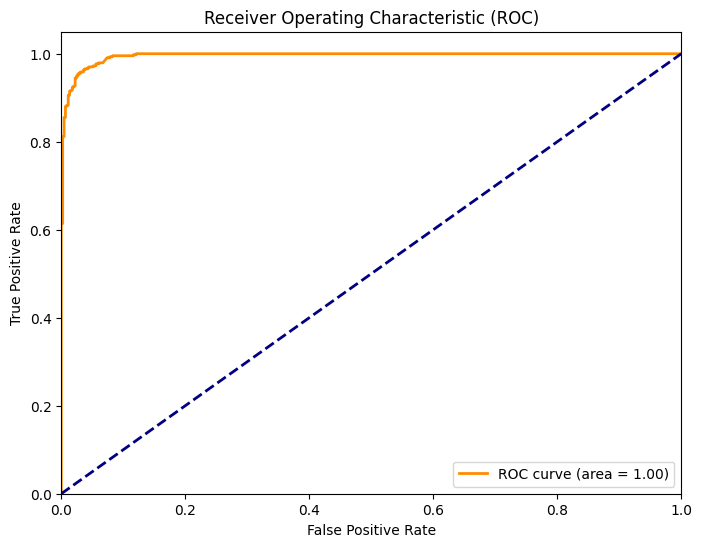

In [81]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

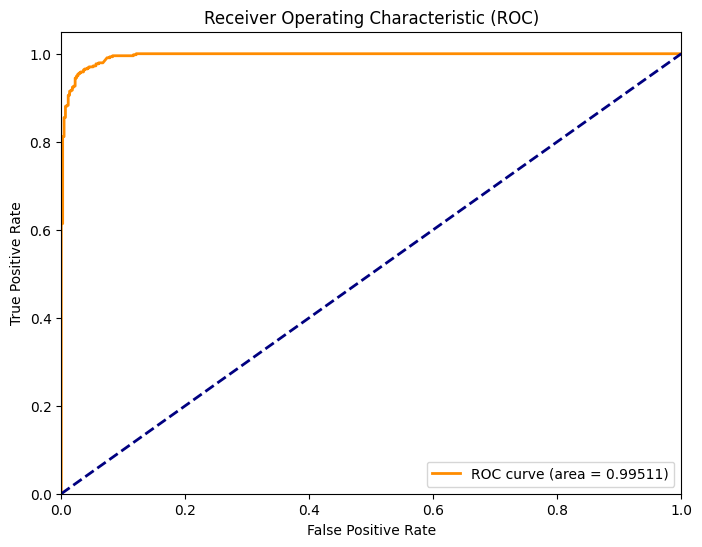

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(np.concatenate([true_class[0].ravel() for true_class in y_true]),
    np.concatenate([predicted_class[0].ravel() for predicted_class in y_scores]))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()
